In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd.functional import jvp
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_s_curve

random_state = 42

In [42]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, z):
        return self.fc(z)

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder, data_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.data_dim = data_dim
        self.latent_dim = latent_dim
    
    def forward(self, x):
        # Encode the input data
        z = self.encoder(x)
        
        # Decode the latent representation
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed
    
    def encode(self, x):
        # Encode the input data to get the latent representation
        with torch.no_grad():
            z = self.encoder(x)
        return z
    
    def decode(self, z):
        # Decode the latent representation to get the reconstructed data
        with torch.no_grad():
            x_reconstructed = self.decoder(z)
        return x_reconstructed
    
    def get_loss(self, x):
        # Compute the reconstruction loss
        x_reconstructed = self.forward(x)
        loss = nn.MSELoss()(x_reconstructed, x)
        return loss
    
    def train(self, data, epochs=1000, batch_size=64, learning_rate=0.001):        
        # Define loss function and optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        # Training loop
        for epoch in range(epochs):
            for i in range(0, len(data), batch_size):
                batch_data = data[i:i+batch_size]

                # Compute loss
                loss = self.get_loss(batch_data)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
class IsotropicAutoencoder(Autoencoder):
    def __init__(self, encoder, decoder, data_dim, latent_dim, lambda_iso=0.1):
        super(IsotropicAutoencoder, self).__init__(encoder, decoder, data_dim, latent_dim)
        self.encoder = encoder
        self.decoder = decoder
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.lambda_iso = lambda_iso
    
    def get_loss(self, x):
        # Compute the isotropic loss
        z = self.encoder(x)
        # distortion = self.relaxed_distortion_measure(self.decoder, z)
        distortion = self.conformal_loss(self.decoder, z)
        x_reconstructed = self.decoder(z)
        mse = nn.MSELoss()(x_reconstructed, x)# + 0.5 * torch.mean(torch.norm(z, dim=1)**2)
        loss = mse + self.lambda_iso * distortion
        # print(f"Distortion: {distortion.item():.8f}")
        # print(f"Reconstruction Loss: {mse.item():.8f}")
        return loss
    
    # def relaxed_distortion_measure(self, func, z, eta=0.2, create_graph=True):
    #     '''
    #     func: decoder that maps "latent value z" to "data", where z.size() == (batch_size, latent_dim)
    #     '''
    #     bs = len(z)
    #     z_perm = z[torch.randperm(bs)] #?
    #     alpha = (torch.rand(bs) * (1 + 2*eta) - eta).unsqueeze(1).to(z) #?
    #     z_augmented = alpha*z + (1-alpha)*z_perm #?
    #     # z_augmented = z
    #     v = torch.randn(z.size()).to(z)
    #     Jv = torch.autograd.functional.jvp(
    #         func, z_augmented, v=v, create_graph=create_graph)[1]
    #     TrG = torch.sum(Jv.view(bs, -1)**2, dim=1).mean()
    #     JTJv = (torch.autograd.functional.vjp(
    #         func, z_augmented, v=Jv, create_graph=create_graph)[1]).view(bs, -1)
    #     TrG2 = torch.sum(JTJv**2, dim=1).mean()
    #     return TrG2/TrG**2
    
    def isometry_loss(self, func, z, epsilon=1e-8):
        """
        z: (batch_size, latent_dim) latent vectors sampled from Piso
        """
        
        # Sample u ~ Uniform(S^{d-1}), i.e., unit vector on sphere
        u = torch.randn_like(z)
        u = u / (u.norm(dim=1, keepdim=True) + epsilon)

        # Compute Jv = df(z) @ u
        Jv = jvp(func, z, u, create_graph=True)[1]

        # Compute norm of Jv and apply the isometric loss
        Jv_norm = Jv.norm(dim=1)
        loss = ((Jv_norm - 1.0) ** 2).mean()
        
        return loss
    
    def conformal_loss(self, f: callable, z: torch.Tensor) -> torch.Tensor:
        """
        Differentiable conformal loss measuring deviation from angle-preserving properties.
        
        Args:
            f: Differentiable function (typically neural network)
            z: Input tensor (must have requires_grad=True)
            
        Returns:
            Scalar loss value (lower means more conformal)
        """
        # Compute Jacobian matrix
        # J = torch.autograd.functional.jacobian(f, z, create_graph=True)
        B, in_dim = z.shape
        z = z.clone().detach().requires_grad_(True)

        y = f(z)  # (B, out_dim)
        out_dim = y.shape[1]

        jacobian = []

        for i in range(out_dim):
            grads = torch.autograd.grad(
                y[:, i].sum(), z, create_graph=True, retain_graph=True
            )[0]  # shape (B, in_dim)
            jacobian.append(grads.unsqueeze(1))  # shape (B, 1, in_dim)

        J = torch.cat(jacobian, dim=1)
        
        # Handle batch dimensions and reshape for matrix multiplication
        if z.dim() > 1:  # Batched inputs
            J = J.flatten(start_dim=1, end_dim=-2)
        
        # Compute J^T J and expected conformal scaling
        JTJ = torch.bmm(J.transpose(1,2), J)
        n = JTJ.size(1)
        trace = JTJ.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)
        lambda_scalar = trace / n
        
        # Create identity matrix matching device/dtype
        I = torch.eye(n, device=z.device, dtype=z.dtype)
        I = I.reshape((1, n, n))
        I = I.repeat(JTJ.shape[0], 1, 1)
        
        # Calculate Frobenius norm of deviation from conformal condition
        # reshape lambda_scalar to (batch_size, 2,2)
        lambda_scalar = lambda_scalar.reshape((-1, 1, 1))
        lambda_scalar = lambda_scalar.repeat(1, n, n)
        loss = torch.norm(JTJ - lambda_scalar * I, p='fro')**2
        
        return loss

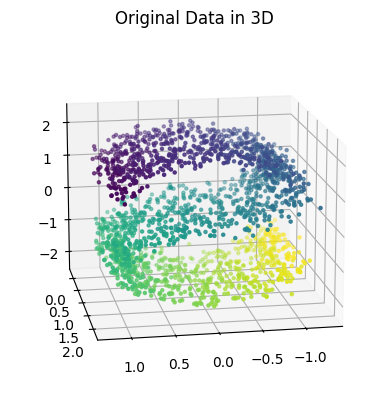

In [43]:
data, labels = make_s_curve(n_samples=2000, noise=0.1, random_state=random_state)
data = torch.tensor(data, dtype=torch.float32)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(15, 80, 0)
plt.show()

In [44]:
encoder = Encoder(input_dim=3, latent_dim=2)
decoder = Decoder(latent_dim=2, output_dim=3)
isotropic_autoencoder = IsotropicAutoencoder(encoder, decoder, data_dim=3, latent_dim=2, lambda_iso=0.01)
isotropic_autoencoder.train(data, epochs=1000)

Epoch [100/1000], Loss: 0.0039
Epoch [200/1000], Loss: 0.0030
Epoch [300/1000], Loss: 0.0028
Epoch [400/1000], Loss: 0.0033
Epoch [500/1000], Loss: 0.0028
Epoch [600/1000], Loss: 0.0025
Epoch [700/1000], Loss: 0.0021
Epoch [800/1000], Loss: 0.0020
Epoch [900/1000], Loss: 0.0019
Epoch [1000/1000], Loss: 0.0019


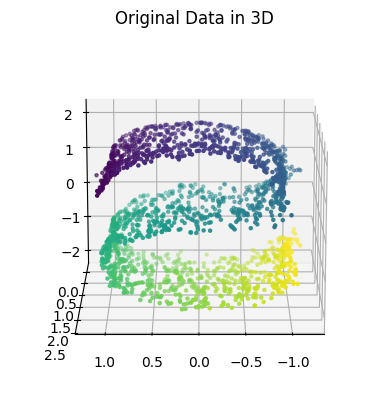

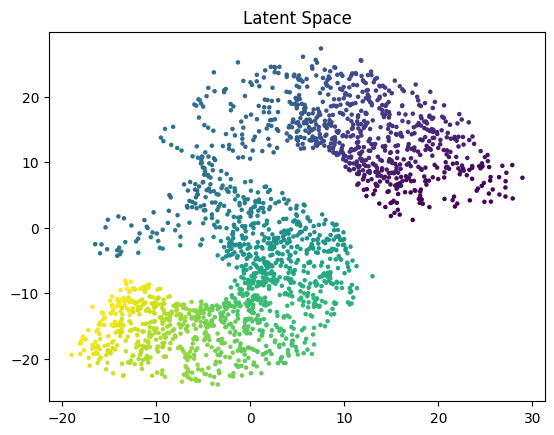

In [45]:
#Encode the data
encoded_data = isotropic_autoencoder.encode(data)
# Decode the data
decoded_data = isotropic_autoencoder.decode(encoded_data)

# Visualize the reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(decoded_data[:, 0], decoded_data[:, 1], decoded_data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(15, 90, 0)
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [ ]:
num = 900
J = torch.zeros((num, 2, 2))
for i in range(num):
    latent = encoder(data[i:i+1])
    jac = torch.autograd.functional.jacobian(decoder, latent)
    jac = jac[0,:,0,:]
    J[i] = jac.T @ jac
print(J.mean(dim=0))
print(J.std(dim=0))
print(J.max(dim=0).values)
print(J.min(dim=0).values)

tensor([[2.4681e-02, 3.6205e-05],
        [3.6205e-05, 2.6564e-02]])
tensor([[0.0134, 0.0088],
        [0.0088, 0.0164]])


In [57]:
encoder = Encoder(input_dim=3, latent_dim=2)
decoder = Decoder(latent_dim=2, output_dim=3)
isotropic_autoencoder = IsotropicAutoencoder(encoder, decoder, data_dim=3, latent_dim=2, lambda_iso=0.1)
isotropic_autoencoder.train(data, epochs=1000)

Epoch [100/1000], Loss: 0.0052
Epoch [200/1000], Loss: 0.0038
Epoch [300/1000], Loss: 0.0030
Epoch [400/1000], Loss: 0.0029
Epoch [500/1000], Loss: 0.0030
Epoch [600/1000], Loss: 0.0027
Epoch [700/1000], Loss: 0.0026
Epoch [800/1000], Loss: 0.0023
Epoch [900/1000], Loss: 0.0022
Epoch [1000/1000], Loss: 0.0020


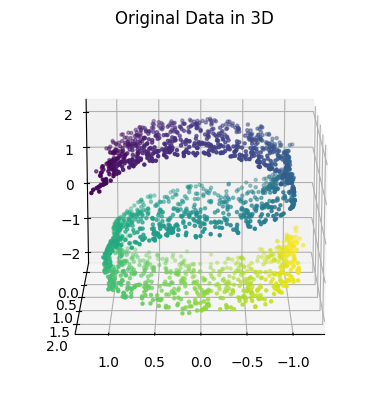

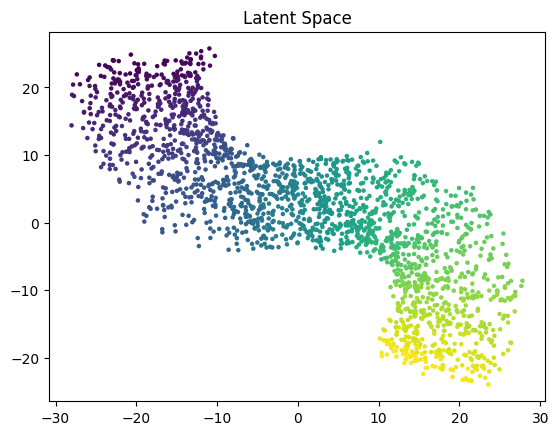

In [58]:
#Encode the data
encoded_data = isotropic_autoencoder.encode(data)
# Decode the data
decoded_data = isotropic_autoencoder.decode(encoded_data)

# Visualize the reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(decoded_data[:, 0], decoded_data[:, 1], decoded_data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(15, 90, 0)
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [59]:
num = 900
J = torch.zeros((num, 2, 2))
for i in range(num):
    latent = encoder(data[i:i+1])
    jac = torch.autograd.functional.jacobian(decoder, latent)
    jac = jac[0,:,0,:]
    J[i] = jac.T @ jac
print(J.mean(dim=0))
print(J.std(dim=0))
print(J.max(dim=0).values)
print(J.min(dim=0).values)

tensor([[0.0220, 0.0001],
        [0.0001, 0.0221]])
tensor([[0.0090, 0.0021],
        [0.0021, 0.0090]])
tensor([[0.0596, 0.0116],
        [0.0116, 0.0577]])
tensor([[ 0.0047, -0.0089],
        [-0.0089,  0.0052]])


In [54]:
encoder = Encoder(input_dim=3, latent_dim=2)
decoder = Decoder(latent_dim=2, output_dim=3)
isotropic_autoencoder = IsotropicAutoencoder(encoder, decoder, data_dim=3, latent_dim=2, lambda_iso=1.0)
isotropic_autoencoder.train(data, epochs=1000)

Epoch [100/1000], Loss: 0.0057
Epoch [200/1000], Loss: 0.0042
Epoch [300/1000], Loss: 0.0033
Epoch [400/1000], Loss: 0.0025
Epoch [500/1000], Loss: 0.0023
Epoch [600/1000], Loss: 0.0025
Epoch [700/1000], Loss: 0.0025
Epoch [800/1000], Loss: 0.0027
Epoch [900/1000], Loss: 0.0026
Epoch [1000/1000], Loss: 0.0024


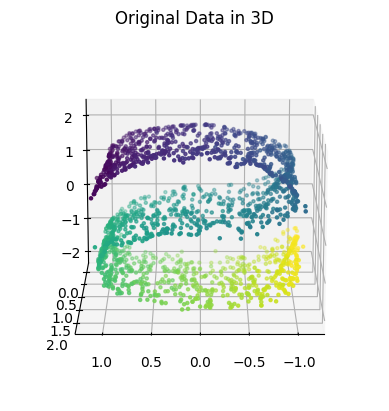

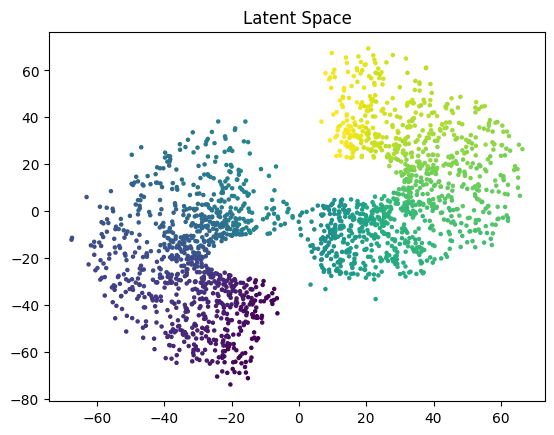

In [55]:
#Encode the data
encoded_data = isotropic_autoencoder.encode(data)
# Decode the data
decoded_data = isotropic_autoencoder.decode(encoded_data)

# Visualize the reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(decoded_data[:, 0], decoded_data[:, 1], decoded_data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(15, 90, 0)
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [56]:
num = 900
J = torch.zeros((num, 2, 2))
for i in range(num):
    latent = encoder(data[i:i+1])
    jac = torch.autograd.functional.jacobian(decoder, latent)
    jac = jac[0,:,0,:]
    J[i] = jac.T @ jac
print(J.mean(dim=0))
print(J.std(dim=0))
print(J.max(dim=0).values)
print(J.min(dim=0).values)

tensor([[3.7355e-03, 6.1103e-05],
        [6.1103e-05, 3.5420e-03]])
tensor([[0.0023, 0.0008],
        [0.0008, 0.0026]])
tensor([[0.0222, 0.0049],
        [0.0049, 0.0278]])
tensor([[ 0.0003, -0.0046],
        [-0.0046,  0.0001]])


In [60]:
encoder = Encoder(input_dim=3, latent_dim=2)
decoder = Decoder(latent_dim=2, output_dim=3)
isotropic_autoencoder = IsotropicAutoencoder(encoder, decoder, data_dim=3, latent_dim=2, lambda_iso=10.0)
isotropic_autoencoder.train(data, epochs=1000)

Epoch [100/1000], Loss: 0.0059
Epoch [200/1000], Loss: 0.0037
Epoch [300/1000], Loss: 0.0026
Epoch [400/1000], Loss: 0.0023
Epoch [500/1000], Loss: 0.0027
Epoch [600/1000], Loss: 0.0027
Epoch [700/1000], Loss: 0.0027
Epoch [800/1000], Loss: 0.0023
Epoch [900/1000], Loss: 0.0026
Epoch [1000/1000], Loss: 0.0023


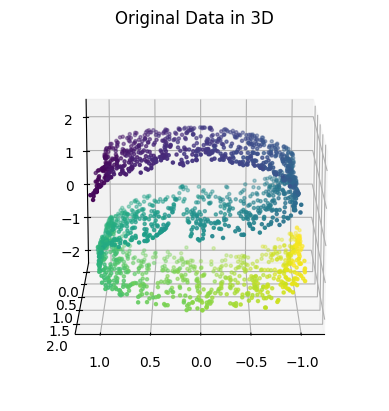

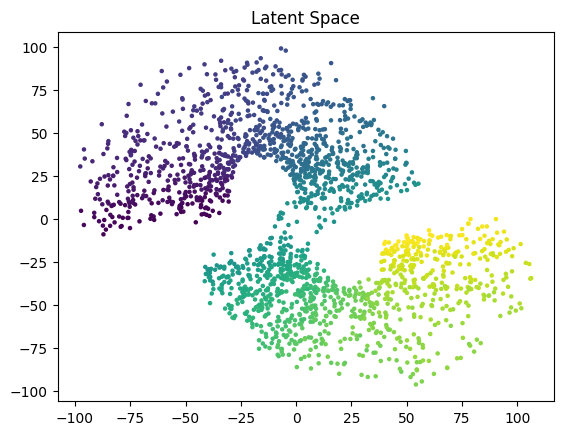

In [61]:
#Encode the data
encoded_data = isotropic_autoencoder.encode(data)
# Decode the data
decoded_data = isotropic_autoencoder.decode(encoded_data)

# Visualize the reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(decoded_data[:, 0], decoded_data[:, 1], decoded_data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(15, 90, 0)
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [62]:
num = 900
J = torch.zeros((num, 2, 2))
for i in range(num):
    latent = encoder(data[i:i+1])
    jac = torch.autograd.functional.jacobian(decoder, latent)
    jac = jac[0,:,0,:]
    J[i] = jac.T @ jac
print(J.mean(dim=0))
print(J.std(dim=0))
print(J.max(dim=0).values)
print(J.min(dim=0).values)

tensor([[ 1.5134e-03, -2.0729e-05],
        [-2.0729e-05,  1.5685e-03]])
tensor([[0.0010, 0.0002],
        [0.0002, 0.0010]])
tensor([[0.0060, 0.0018],
        [0.0018, 0.0064]])
tensor([[ 8.5105e-05, -1.2856e-03],
        [-1.2856e-03,  1.6077e-04]])
